In [5]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [475]:
NUM_TRADING_DAYS = 252
NUM_PORTFOLIOS = 10000

stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

start_date = '2010-01-01'
end_date = '2024-12-28'

In [435]:
def download_data():
    # name of the stock (key) - stock values (2010-1017) as the values
    stock_data = {}

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

    return pd.DataFrame(stock_data)

In [437]:
def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [439]:
def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [441]:
def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [443]:
def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)

In [445]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [447]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [449]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))

    # sharpe ration = portfolio_return / portfolio_volatility
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])

In [451]:
# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [453]:
# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)

In [455]:
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))

In [457]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

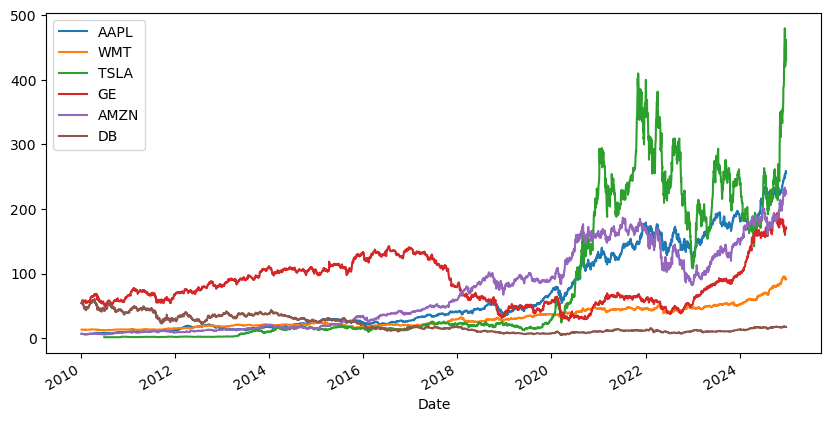

In [459]:
dataset = download_data()
show_data(dataset)

In [460]:
log_daily_returns = calculate_return(dataset)

In [461]:
show_statistics(log_daily_returns)

AAPL    0.245912
WMT     0.130087
TSLA    0.386890
GE      0.076782
AMZN    0.234503
DB     -0.077063
dtype: float64
          AAPL       WMT      TSLA        GE      AMZN        DB
AAPL  0.077717  0.015327  0.057004  0.029988  0.043696  0.037886
WMT   0.015327  0.036813  0.015902  0.012706  0.015312  0.015967
TSLA  0.057004  0.015902  0.326340  0.041277  0.065772  0.056303
GE    0.029988  0.012706  0.041277  0.098704  0.028908  0.061513
AMZN  0.043696  0.015312  0.065772  0.028908  0.106669  0.040150
DB    0.037886  0.015967  0.056303  0.061513  0.040150  0.166474


In [462]:
pweights, means, risks = generate_portfolios(log_daily_returns)

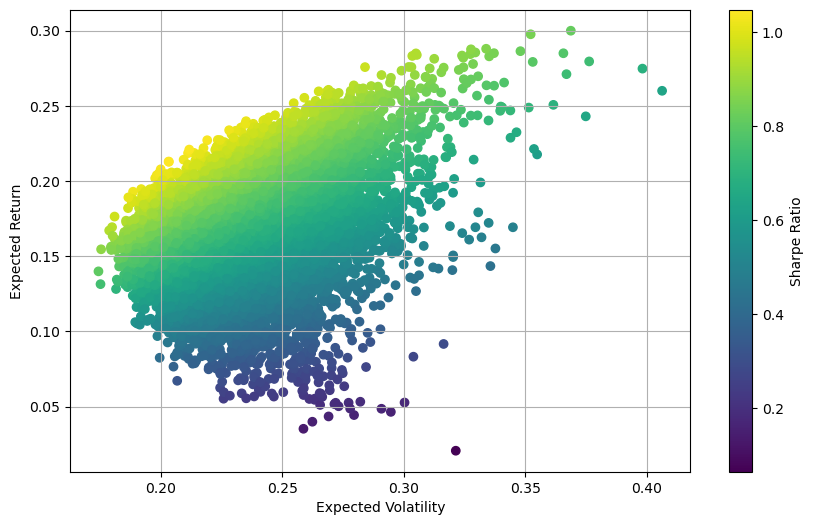

In [463]:
show_portfolios(means, risks)

In [464]:
optimum = optimize_portfolio(pweights, log_daily_returns)

In [465]:
print_optimal_portfolio(optimum, log_daily_returns)

Optimal portfolio:  [0.347 0.404 0.111 0.    0.138 0.   ]
Expected return, volatility and Sharpe ratio:  [0.21319288 0.19859599 1.0735004 ]


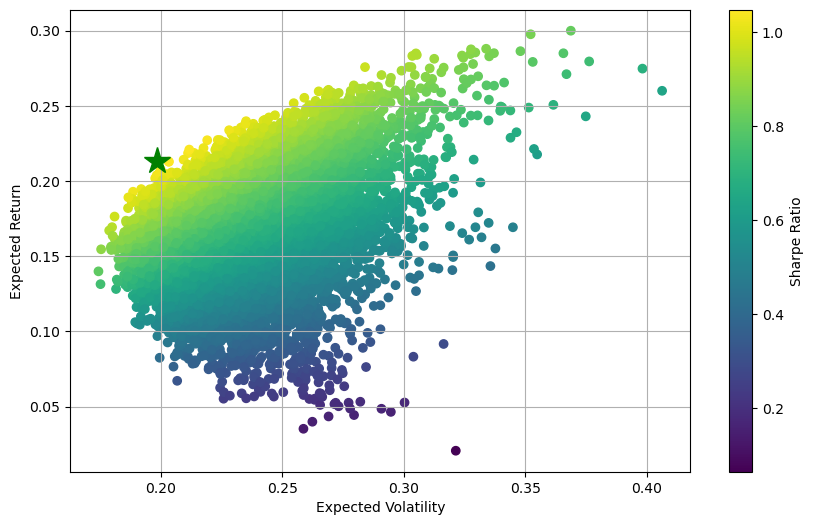

In [469]:
show_optimal_portfolio(optimum, log_daily_returns, means, risks)